In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import SGDClassifier

In [2]:
# This Function takes value of colunn Days of Employed and convert it into datetime format
def Employed_day(total_days):
    today = datetime.date.today()
    employed_date = today + datetime.timedelta(days=total_days)
    years_employed=int((today-employed_date).days/365)
    return years_employed


def calculate_age(days_birth):
    today = datetime.date.today()
    birth_date = today - datetime.timedelta(days=-days_birth)
    age = int((today - birth_date).days / 365)
    return age

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

DATA IMPORT

In [3]:
credit_record=pd.read_csv("credit_record.csv")
application_record=pd.read_csv("application_record.csv")
credit_record.head()

#MONTH_BALANCE:
#The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
#STATUS:
#0 = 1-29 days past due 1
#1 = 30-59 days past due 2
#2 = 60-89 days overdue 3
#3 = 90-119 days overdue 4
#4 = 120-149 days overdue 5
#5 = Overdue or bad debts, write offs for more than  150 days
#C = pad off that month 
#X: no loan for the month

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

GROUPING OF "ID" AND CALCULATION OF THE PERIOD OF EXISTENCE OF THE FINANCING

In [4]:
grouped_df = credit_record.groupby('ID')
pivot_credit = credit_record.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_credit['first_month'] = grouped_df['MONTHS_BALANCE'].min()
pivot_credit['last_month'] = grouped_df['MONTHS_BALANCE'].max()

pivot_credit['ID'] = pivot_credit.index
pivot_credit = pivot_credit[['ID', 'first_month', 'last_month']]
pivot_credit.loc[:, 'MONTHS_OPENING'] = pivot_credit['last_month'] - pivot_credit['first_month']
pivot_credit.reset_index(drop = True,inplace = True)

#join between pivot table and the original dataset credit_record
credit_record = pd.merge(credit_record, pivot_credit, on = 'ID', how = 'left')
credit_record=credit_record.drop(columns=["first_month", "last_month"])

credit_record

,ID,MONTHS_BALANCE,STATUS,MONTHS_OPENING
0,5001711,0,X,3
1,5001711,-1,0,3
2,5001711,-2,0,3
3,5001711,-3,0,3
4,5001712,0,C,18
...,...,...,...,...
1048570,5150487,-25,C,29
1048571,5150487,-26,C,29
1048572,5150487,-27,C,29
1048573,5150487,-28,C,29


In [5]:
application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
application_record['DAYS_BIRTH'] = application_record['DAYS_BIRTH'].apply(calculate_age)
application_record.rename(columns={'DAYS_BIRTH': 'AGE'}, inplace=True)
application_record['DAYS_EMPLOYED'] = application_record['DAYS_EMPLOYED'].apply(Employed_day)
application_record.rename(columns={'DAYS_EMPLOYED': 'YEARS_EMPLOYED'}, inplace=True)

application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,32,12,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,58,3,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52,8,1,0,1,1,Sales staff,1.0


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

REMOVAL OF FEATURES FOR WICH THE CREDIT CARD'S ISSUING CAN'T BE DENIED (AGE, GENDER, FAMILY STATUS AND FAMILY STATUS)

We filter the application_record dataset to exclude data that credit card companies that cannot discriminate based upon, namely gender, age, and marital status

In [7]:
application_record = application_record.drop(columns=['CODE_GENDER', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE'])

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

CARD APPROVAL DECISION ON THE STATUS OF PAYMENTS

Any customer who has an X for a status, indicating that they do not currently have a loan, will be omitted due to a lack of information about their credit history

In [8]:
credit_record=credit_record[credit_record['STATUS'] != 'X']

In [9]:
credit_record["STATUS"].value_counts()

C    442031
0    383120
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [10]:
credit_record

,ID,MONTHS_BALANCE,STATUS,MONTHS_OPENING
1,5001711,-1,0,3
2,5001711,-2,0,3
3,5001711,-3,0,3
4,5001712,0,C,18
5,5001712,-1,C,18
...,...,...,...,...
1048570,5150487,-25,C,29
1048571,5150487,-26,C,29
1048572,5150487,-27,C,29
1048573,5150487,-28,C,29


In [11]:
credit_record = credit_record[credit_record['MONTHS_BALANCE'] != 0]

In [12]:
credit_record['STATUS'] = credit_record['STATUS'].replace('C', '6')

C:\Users\utente\AppData\Local\Temp\ipykernel_24252\2976533969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_record['STATUS'] = credit_record['STATUS'].replace('C', '6')


In [13]:
#Any customer who is less than 30 days overdue will be considered approved because they have demonstrated an ability to avoid excessive late payments  
#Any customer who is greater than 30 days overdue will be considered denied because they have demonstrated a lack of ability to pay on time
#APPROVED=0
#NOT APPROVED=1

def approval(credit_record):
    if(credit_record['STATUS'] == '1' or credit_record['STATUS'] == '2' or credit_record['STATUS'] == '3' or credit_record['STATUS'] == '4' or credit_record['STATUS'] == '5'): return 0
    elif(credit_record['STATUS'] == '6' or credit_record['STATUS'] == '0'): return 1

credit_record['CARD_APPROVAL_SCORE'] = credit_record.apply(approval, axis=1)

C:\Users\utente\AppData\Local\Temp\ipykernel_24252\2472184639.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_record['CARD_APPROVAL_SCORE'] = credit_record.apply(approval, axis=1)


In [14]:
credit_record.head()

,ID,MONTHS_BALANCE,STATUS,MONTHS_OPENING,CARD_APPROVAL_SCORE
1,5001711,-1,0,3,1
2,5001711,-2,0,3,1
3,5001711,-3,0,3,1
5,5001712,-1,6,18,1
6,5001712,-2,6,18,1


In [15]:
credit_record["CARD_APPROVAL_SCORE"].value_counts()

1    798624
0     13790
Name: CARD_APPROVAL_SCORE, dtype: int64

In [16]:
credit_record = credit_record.drop(columns=["MONTHS_BALANCE"])
credit_record

,ID,STATUS,MONTHS_OPENING,CARD_APPROVAL_SCORE
1,5001711,0,3,1
2,5001711,0,3,1
3,5001711,0,3,1
5,5001712,6,18,1
6,5001712,6,18,1
...,...,...,...,...
1048570,5150487,6,29,1
1048571,5150487,6,29,1
1048572,5150487,6,29,1
1048573,5150487,6,29,1


In [17]:
#we group the IDs by averaging the values ​​in the other columns. For each customer we will see the average duration of their financing and their average risk

credit_record= credit_record.groupby('ID').mean().reset_index()
credit_record

,ID,MONTHS_OPENING,CARD_APPROVAL_SCORE
0,5001711,3.0,1.000000
1,5001712,18.0,1.000000
2,5001717,21.0,1.000000
3,5001718,38.0,0.928571
4,5001719,42.0,1.000000
...,...,...,...
40934,5150480,25.0,1.000000
40935,5150482,17.0,1.000000
40936,5150484,12.0,1.000000
40937,5150485,1.0,1.000000


In [18]:
credit_record["CARD_APPROVAL_SCORE"].value_counts()

1.000000    35716
0.857143      167
0.833333      154
0.875000      151
0.888889      148
            ...  
0.661017        1
0.633333        1
0.872727        1
0.787234        1
0.217391        1
Name: CARD_APPROVAL_SCORE, Length: 396, dtype: int64

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

SELECTION OF UNIQUE ID IN THE DATASETS

In [19]:
print(application_record.nunique())
print("----------------------------")
print(credit_record.nunique())

ID                     438510
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_HOUSING_TYPE           6
AGE                        50
YEARS_EMPLOYED             48
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
CNT_FAM_MEMBERS            13
dtype: int64
----------------------------
ID                     40939
MONTHS_OPENING            61
CARD_APPROVAL_SCORE      396
dtype: int64


Once we have identified the average riskiness of the customers, we identify the unique "ID" in the two datasets and join the two datasets only with the unique "ID" in common

In [20]:
print("Number of unique ID that are consistent in both datasets:", application_record[application_record['ID'].isin(credit_record['ID'])]['ID'].nunique())

#adjust the dataframes so that we only work with the consistent IDs
application_record = application_record[application_record['ID'].isin(credit_record['ID'])]
credit_record = credit_record[credit_record['ID'].isin(application_record['ID'])]
print("Number of ID in application_record:", application_record['ID'].nunique())
print("Number of ID in credit_record:", credit_record['ID'].nunique())

Number of unique ID that are consistent in both datasets: 32684
Number of ID in application_record: 32684
Number of ID in credit_record: 32684


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

COMPLETE DATAFRAME

In [21]:
df = application_record.merge(credit_record, on='ID')
df.head(5)

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_OPENING,CARD_APPROVAL_SCORE
0,5008804,Y,Y,0,427500.0,Working,Higher education,Rented apartment,32,12,1,1,0,0,2.0,15.0,0.928571
1,5008805,Y,Y,0,427500.0,Working,Higher education,Rented apartment,32,12,1,1,0,0,2.0,14.0,0.923077
2,5008806,Y,Y,0,112500.0,Working,Secondary / secondary special,House / apartment,58,3,1,0,0,0,2.0,29.0,1.000000
3,5008808,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,52,8,1,0,1,1,1.0,4.0,1.000000
4,5008810,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,52,8,1,0,1,1,1.0,26.0,1.000000


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

VARIABLES ENCODING

In [22]:
income_type = {'Working':1,'Commercial associate':2,'Pensioner':3,'State servant':4,'Student':5}
education_type = {'Secondary':1, 'Secondary / secondary special':2,'Higher education':3,'Incomplete higher':4,'Lower secondary':5,'Academic degree':6}
family_status = {'Married':1,'Single':2,'Civil marriage':3,'Separated':4,'Widow':5, 'Single / not married':6}
housing_type = {'House / apartment':1,'With parents':2,'Municipal apartment':3,'Rented apartment':4,'Office apartment':5,'Co-op apartment':6}
own_car={"Y":1, "N":0}
own_realty={"Y":1, "N":0}

In [23]:
df.replace({'NAME_INCOME_TYPE':income_type},inplace=True)
df.replace({'NAME_EDUCATION_TYPE':education_type},inplace=True)
df.replace({'NAME_FAMILY_STATUS':family_status},inplace=True)
df.replace({'NAME_HOUSING_TYPE':housing_type},inplace=True)
df.replace({"FLAG_OWN_CAR":own_car}, inplace=True)
df.replace({"FLAG_OWN_REALTY":own_realty}, inplace=True)
df.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_OPENING,CARD_APPROVAL_SCORE
0,5008804,1,1,0,427500.0,1,3,4,32,12,1,1,0,0,2.0,15.0,0.928571
1,5008805,1,1,0,427500.0,1,3,4,32,12,1,1,0,0,2.0,14.0,0.923077
2,5008806,1,1,0,112500.0,1,2,1,58,3,1,0,0,0,2.0,29.0,1.000000
3,5008808,0,1,0,270000.0,2,2,1,52,8,1,0,1,1,1.0,4.0,1.000000
4,5008810,0,1,0,270000.0,2,2,1,52,8,1,0,1,1,1.0,26.0,1.000000


In [24]:
#we assign a value of 1 to customers who have a CARD_APPROVAL_SCORE value greater than 0.8, which means that they are reliable, while we give a value of 0 to all others, 
#which means that they are more risky

df['CARD_APPROVAL'] = df['CARD_APPROVAL_SCORE'].apply(lambda x: 1 if x >= 0.8 else 0)

df.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_OPENING,CARD_APPROVAL_SCORE,CARD_APPROVAL
0,5008804,1,1,0,427500.0,1,3,4,32,12,1,1,0,0,2.0,15.0,0.928571,1
1,5008805,1,1,0,427500.0,1,3,4,32,12,1,1,0,0,2.0,14.0,0.923077,1
2,5008806,1,1,0,112500.0,1,2,1,58,3,1,0,0,0,2.0,29.0,1.000000,1
3,5008808,0,1,0,270000.0,2,2,1,52,8,1,0,1,1,1.0,4.0,1.000000,1
4,5008810,0,1,0,270000.0,2,2,1,52,8,1,0,1,1,1.0,26.0,1.000000,1


In [25]:
df = df.drop(columns=["CARD_APPROVAL_SCORE"])
df.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_HOUSING_TYPE,AGE,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_OPENING,CARD_APPROVAL
0,5008804,1,1,0,427500.0,1,3,4,32,12,1,1,0,0,2.0,15.0,1
1,5008805,1,1,0,427500.0,1,3,4,32,12,1,1,0,0,2.0,14.0,1
2,5008806,1,1,0,112500.0,1,2,1,58,3,1,0,0,0,2.0,29.0,1
3,5008808,0,1,0,270000.0,2,2,1,52,8,1,0,1,1,1.0,4.0,1
4,5008810,0,1,0,270000.0,2,2,1,52,8,1,0,1,1,1.0,26.0,1


In [26]:
#let's see the number of Good customers and Bad customers
approval_counts = df['CARD_APPROVAL'].value_counts()

print(f"GOOD CUSTOMERS (1): {approval_counts[1]}")
print(f"BAD CUSTOMERS (0): {approval_counts[0]}")

GOOD CUSTOMERS (1): 31776
BAD CUSTOMERS (0): 908


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

VARIABLES CORRELATION

In [27]:

def create_heatmap(df):
    plt.figure(figsize=(8,4))  #It is used to decide the size of the graph
    sns.heatmap(df.corr(), annot=True, annot_kws={"size":6}) 
    plt.show()

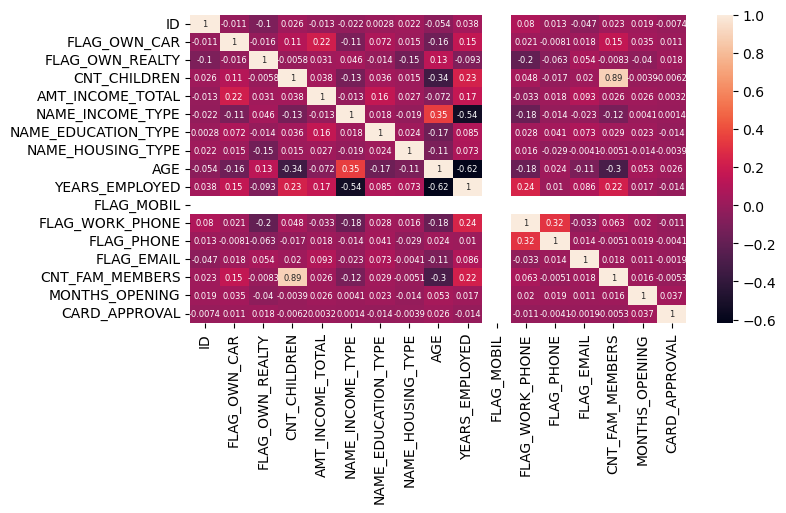

In [28]:
create_heatmap(df)

In [29]:
#Removing variables with a low correlations
df = df.drop(columns=["FLAG_EMAIL", "MONTHS_OPENING", "NAME_EDUCATION_TYPE", "ID", "FLAG_MOBIL", "NAME_HOUSING_TYPE"])
df.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,AGE,YEARS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,CARD_APPROVAL
0,1,1,0,427500.0,1,32,12,1,0,2.0,1
1,1,1,0,427500.0,1,32,12,1,0,2.0,1
2,1,1,0,112500.0,1,58,3,0,0,2.0,1
3,0,1,0,270000.0,2,52,8,0,1,1.0,1
4,0,1,0,270000.0,2,52,8,0,1,1.0,1


In [30]:
df["CARD_APPROVAL"].value_counts()

#the dataset is unbalanced with a majority of datas in the class 1

1    31776
0      908
Name: CARD_APPROVAL, dtype: int64

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

MODEL CREATION

In [31]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve, roc_auc_score


In [32]:
X=df.drop('CARD_APPROVAL', axis=1).values
y=df['CARD_APPROVAL'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [34]:
#EVALUATION MODEL FUNCTION
def evaluate_model(y_true, y_pred):
    report = classification_report(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    report += f"\n\nR-squared: {r2}"

    return report

In [41]:
#LOGISTIC REGRESSION MODEL
def model_lr(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    smote_enn = SMOTEENN()
    X_train_resample, y_train_resample = smote_enn.fit_resample(X_train, y_train)

    ss = StandardScaler()
    X_train_resample = ss.fit_transform(X_train_resample)
    X_test = ss.transform(X_test)
    
    class_weight = {0: 0.7, 1: 0.3} 
    
    # Inizializza il modello utilizzando SGDClassifier con gradient descent
    lr = SGDClassifier(loss='log_loss', class_weight=class_weight, max_iter=100)
    
    # Adatta il modello utilizzando gli adattatori di addestramento
    lr.fit(X_train_resample, y_train_resample)
    
    # Ottieni le previsioni
    y_pred_train = lr.predict(X_train_resample)
    y_pred_test = lr.predict(X_test)
    
    train_report = evaluate_model(y_train_resample, y_pred_train)
    test_report = evaluate_model(y_test, y_pred_test)

    print("Classification Report - Train Set:")
    print(train_report)
    print(confusion_matrix(y_train_resample, y_pred_train))
    print("-----------------------------------------------------------------")
    print("Classification Report - Test Set:")
    print(test_report)
    print(confusion_matrix(y_test, y_pred_test))

#---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#RANDOM FOREST
def model_rfc(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

    smote_enn = SMOTEENN()
    X_train_resample, y_train_resample = smote_enn.fit_resample(X_train, y_train)

    ss = StandardScaler()
    X_train_resample = ss.fit_transform(X_train_resample)
    X_test = ss.transform(X_test)
    
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train_resample, y_train_resample)
    sfm = SelectFromModel(estimator=lasso, threshold=0.0001)
    
    rfc = RandomForestClassifier(class_weight={0: 0.70, 1: 0.30}, max_depth=10000, min_samples_leaf=1, n_estimators=10)
    rfc.fit(X_train_resample, y_train_resample)

    y_pred_train_proba = rfc.predict_proba(X_train_resample)
    y_pred_test_proba = rfc.predict_proba(X_test)

    threshold = 0.0001  # Soglia di classificazione

    y_pred_train = (y_pred_train_proba[:, 1] > threshold).astype(int)
    y_pred_test = (y_pred_test_proba[:, 1] > threshold).astype(int)

    train_report = evaluate_model(y_train_resample, y_pred_train)
    test_report = evaluate_model(y_test, y_pred_test)

    X_proba_train = y_pred_train_proba[:, 1]
    X_proba_test = y_pred_test_proba[:, 1]
    
    print("Classification Report - Train Set:")
    print(train_report)
    print(confusion_matrix(y_train_resample, y_pred_train))
    print("-----------------------------------------------------------------")
    print("Classification Report - Test Set:")
    print(test_report)
    print(confusion_matrix(y_test, y_pred_test))
    
    # Plot dell'importanza delle variabili
    importances = rfc.feature_importances_
    feature_names = list(df.columns[:-1])  # Escludi l'ultima colonna, che è la variabile target
    plt.bar(range(len(importances)), importances, tick_label=feature_names)
    plt.xticks(rotation=90)
    plt.xlabel('Variables')
    plt.ylabel('Importance')
    plt.title('Variables Importance')
    plt.show()
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#RANDOM FOREST CLASSIFIER CON CROSS VALIDATION
def model_rfc_cross_validation(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

    smote_enn = SMOTEENN()
    X_train_resample, y_train_resample = smote_enn.fit_resample(X_train, y_train)

    ss = StandardScaler()
    X_train_resample = ss.fit_transform(X_train_resample)
    X_test = ss.transform(X_test)
    
    lasso = Lasso(alpha=5)
    lasso.fit(X_train_resample, y_train_resample)
    sfm = SelectFromModel(estimator=lasso, threshold=0.0001)
    
    rfc = RandomForestClassifier(class_weight={0: 0.90, 1: 0.10}, max_depth=100000, min_samples_leaf=1, n_estimators=100)
    
    #------------ Cross Validation ------------
    scores = cross_val_score(rfc, X_train_resample, y_train_resample, cv=5, scoring='accuracy')
    print("Cross Validation Scores:", scores)
    print("Mean Cross Validation Score:", scores.mean())
    #------------------------------------------
    
    rfc.fit(X_train_resample, y_train_resample)

    y_pred_train_proba = rfc.predict_proba(X_train_resample)
    y_pred_test_proba = rfc.predict_proba(X_test)

    threshold = 0.0001  # Soglia di classificazione

    y_pred_train = (y_pred_train_proba[:, 1] > threshold).astype(int)
    y_pred_test = (y_pred_test_proba[:, 1] > threshold).astype(int)

    train_report = evaluate_model(y_train_resample, y_pred_train)
    test_report = evaluate_model(y_test, y_pred_test)

    print("Classification Report - Train Set:")
    print(train_report)
    print(confusion_matrix(y_train_resample, y_pred_train))
    print("-----------------------------------------------------------------")
    print("Classification Report - Test Set:")
    print(test_report)
    print(confusion_matrix(y_test, y_pred_test))

    importances = rfc.feature_importances_
    feature_names = list(df.columns[:-1])  # Escludi l'ultima colonna, che è la variabile target
    plt.bar(range(len(importances)), importances, tick_label=feature_names)
    plt.xticks(rotation=90)
    plt.xlabel('Variables')
    plt.ylabel('Importance')
    plt.title('Variables Importance')
    plt.show()

    y_train_proba = rfc.predict_proba(X_train_resample)[:, 1]
    y_test_proba = rfc.predict_proba(X_test)[:, 1]

    train_fpr, train_tpr, _ = roc_curve(y_train_resample, y_train_proba)
    test_fpr, test_tpr, _ = roc_curve(y_test, y_test_proba)

    plt.plot(train_fpr, train_tpr, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve')
    plt.legend()
    plt.show()
    
    train_auc = roc_auc_score(y_train_resample, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    print("Train AUC-ROC:", train_auc)
    print("Test AUC-ROC:", test_auc)
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#XGBOOST CLASSIFIER
def model_xgboost(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    smote_enn = SMOTEENN()
    X_train_resample, y_train_resample = smote_enn.fit_resample(X_train, y_train)

    ss = StandardScaler()
    X_train_resample = ss.fit_transform(X_train_resample)
    X_test = ss.transform(X_test)

    #weight_ratio = float(len(y_train[y_train == 1]) / len(y_train[y_train == 0]))
    class_weight = 0.65/0.35

    xgb_clf = XGBClassifier(max_depth=15, learning_rate=0.4,  n_estimators=2000, scale_pos_weight=class_weight)
    xgb_clf.fit(X_train_resample, y_train_resample)

    y_pred_train_proba = xgb_clf.predict_proba(X_train_resample)
    y_pred_test_proba = xgb_clf.predict_proba(X_test)

    threshold = 0.05  # Soglia di classificazione

    y_pred_train = (y_pred_train_proba[:, 1] > threshold).astype(int)
    y_pred_test = (y_pred_test_proba[:, 1] > threshold).astype(int)

    train_report = evaluate_model(y_train_resample, y_pred_train)
    test_report = evaluate_model(y_test, y_pred_test)

    print("Classification Report - Train Set:")
    print(train_report)
    print(confusion_matrix(y_train_resample, y_pred_train))
    print("-----------------------------------------------------------------")
    print("Classification Report - Test Set:")
    print(test_report)
    print(confusion_matrix(y_test, y_pred_test))
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#SUPPORT VECTOR
def svc(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    smote_enn = SMOTEENN()
    X_train, y_train = smote_enn.fit_resample(X_train, y_train)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    svc = SVC(kernel="rbf", probability=True)
    svc.fit(X_train, y_train)
    
    y_pred_train_proba = svc.predict_proba(X_train)
    y_pred_test_proba = svc.predict_proba(X_test)

    threshold = 0.5  # Soglia di classificazione

    # Applica la soglia di classificazione
    y_pred_train = (y_pred_train_proba[:, 1] > threshold).astype(int)
    y_pred_test = (y_pred_test_proba[:, 1] > threshold).astype(int)

    train_report = evaluate_model(y_train, y_pred_train)
    test_report = evaluate_model(y_test, y_pred_test)

    print("Classification Report - Train Set:")
    print(train_report)
    print(confusion_matrix(y_train, y_pred_train))
    print("-----------------------------------------------------------------")
    print("Classification Report - Test Set:")
    print(test_report)
    print(confusion_matrix(y_test, y_pred_test))
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#BAYES
def model_bayes(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    smote_enn = SMOTEENN()
    X_train_resample, y_train_resample = smote_enn.fit_resample(X_train, y_train)

    mms = MinMaxScaler()
    X_train_resample = mms.fit_transform(X_train_resample)
    X_test = mms.transform(X_test)
    
    # Applicazione del modello di classificazione bayesiana
    bayes = MultinomialNB()
    bayes.fit(X_train_resample, y_train_resample)

    y_pred_train = bayes.predict(X_train_resample)
    y_pred_test = bayes.predict(X_test)

    train_report = evaluate_model(y_train_resample, y_pred_train)
    test_report = evaluate_model(y_test, y_pred_test)

    print("Classification Report - Train Set:")
    print(train_report)
    print(confusion_matrix(y_train_resample, y_pred_train))
    print("-----------------------------------------------------------------")
    print("Classification Report - Test Set:")
    print(test_report)
    print(confusion_matrix(y_test, y_pred_test))   
#--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#MLPClassifier
def mlp(df):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    smote_enn = SMOTEENN()
    X_train, y_train = smote_enn.fit_resample(X_train, y_train)

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.transform(X_test)

    mlp = MLPClassifier(hidden_layer_sizes=(300,), activation='relu', solver='adam', random_state=42, alpha=0.0001, max_iter=2000,
                      early_stopping=True, warm_start=True)
    mlp.fit(X_train, y_train)
    
    y_pred_train_proba = mlp.predict_proba(X_train)
    y_pred_test_proba = mlp.predict_proba(X_test)

    threshold = 0.05  # Soglia di classificazione

    # Applica la soglia di classificazione
    y_pred_train = (y_pred_train_proba[:, 1] > threshold).astype(int)
    y_pred_test = (y_pred_test_proba[:, 1] > threshold).astype(int)

    train_report = evaluate_model(y_train, y_pred_train)
    test_report = evaluate_model(y_test, y_pred_test)

    print("Classification Report - Train Set:")
    print(train_report)
    print(confusion_matrix(y_train, y_pred_train))
    print("-----------------------------------------------------------------")
    print("Classification Report - Test Set:")
    print(test_report)
    print(confusion_matrix(y_test, y_pred_test))

In [42]:
#LOGISTIC REGRESSION MODEL 
model_lr(df)

Classification Report - Train Set:
              precision    recall  f1-score   support

           0       0.51      0.96      0.67     18951
           1       0.75      0.11      0.19     19403

    accuracy                           0.53     38354
   macro avg       0.63      0.54      0.43     38354
weighted avg       0.63      0.53      0.43     38354


R-squared: -0.8795956673600542
[[18244   707]
 [17313  2090]]
-----------------------------------------------------------------
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.03      0.92      0.06       279
           1       0.98      0.10      0.18      9527

    accuracy                           0.12      9806
   macro avg       0.50      0.51      0.12      9806
weighted avg       0.95      0.12      0.18      9806


R-squared: -30.730759550389315
[[ 258   21]
 [8580  947]]


Classification Report - Train Set:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     17268
           1       0.97      1.00      0.99     17844

    accuracy                           0.99     35112
   macro avg       0.99      0.99      0.99     35112
weighted avg       0.99      0.99      0.99     35112


R-squared: 0.9424543246317127
[[16763   505]
 [    0 17844]]
-----------------------------------------------------------------
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.44      0.09      0.14       324
           1       0.97      1.00      0.99     11116

    accuracy                           0.97     11440
   macro avg       0.71      0.54      0.56     11440
weighted avg       0.96      0.97      0.96     11440


R-squared: -0.054558216606914955
[[   28   296]
 [   36 11080]]


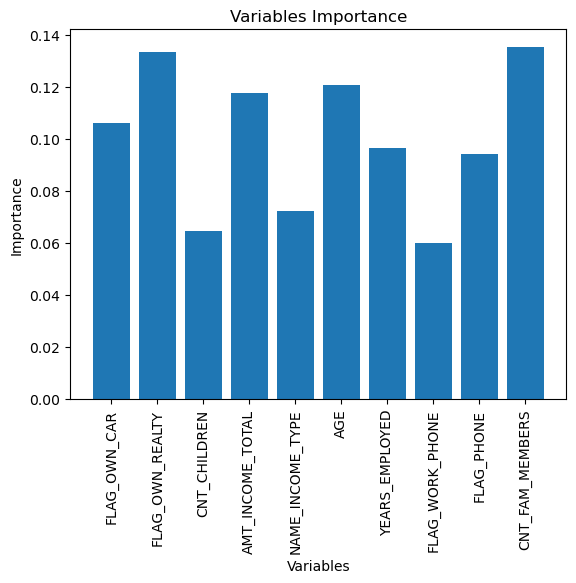

In [43]:
#RANDOM FOREST CLASSIFIER MODEL
model_rfc(df)

Cross Validation Scores: [0.97936781 0.99894194 0.99867742 0.99854517 0.99880952]
Mean Cross Validation Score: 0.994868372160397
Classification Report - Train Set:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94     18407
           1       0.90      1.00      0.95     19397

    accuracy                           0.95     37804
   macro avg       0.95      0.94      0.95     37804
weighted avg       0.95      0.95      0.95     37804


R-squared: 0.7835781685756229
[[16363  2044]
 [    0 19397]]
-----------------------------------------------------------------
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.58      0.10      0.17       278
           1       0.97      1.00      0.99      9528

    accuracy                           0.97      9806
   macro avg       0.78      0.55      0.58      9806
weighted avg       0.96      0.97      0.96      9806


R-squared: 0.000439

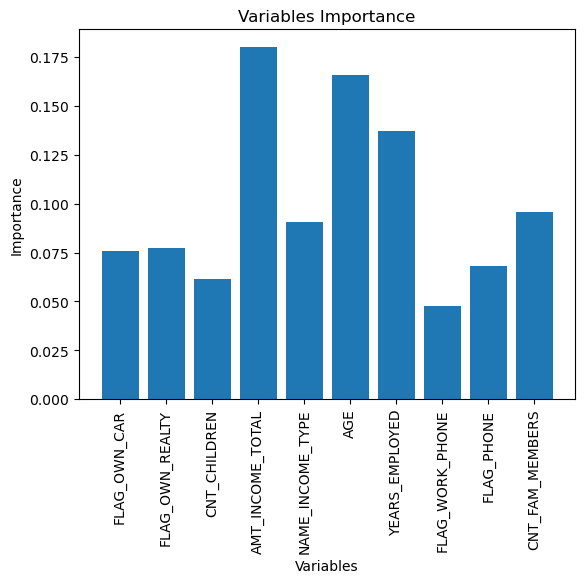

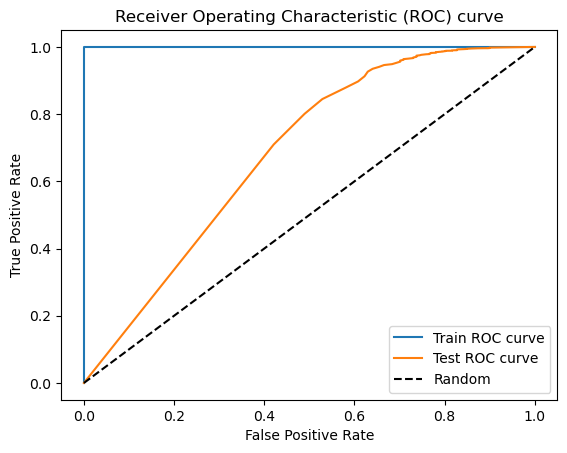

Train AUC-ROC: 1.0
Test AUC-ROC: 0.6853012552174885


In [44]:
#RANDOM FOREST CLASSIFIER MODEL CROSS VALIDATION
model_rfc_cross_validation(df)

In [39]:
model_xgboost(df)

Classification Report - Train Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18436
           1       1.00      1.00      1.00     19265

    accuracy                           1.00     37701
   macro avg       1.00      1.00      1.00     37701
weighted avg       1.00      1.00      1.00     37701


R-squared: 0.9951171319477453
[[18390    46]
 [    0 19265]]
-----------------------------------------------------------------
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.32      0.19      0.24       262
           1       0.98      0.99      0.98      9544

    accuracy                           0.97      9806
   macro avg       0.65      0.59      0.61      9806
weighted avg       0.96      0.97      0.96      9806


R-squared: -0.2470598209658117
[[  49  213]
 [ 105 9439]]


In [40]:
model_bayes(df)

Classification Report - Train Set:
              precision    recall  f1-score   support

           0       0.53      0.31      0.39     18190
           1       0.54      0.75      0.63     19400

    accuracy                           0.54     37590
   macro avg       0.54      0.53      0.51     37590
weighted avg       0.54      0.54      0.51     37590


R-squared: -0.8609332759021329
[[ 5556 12634]
 [ 4836 14564]]
-----------------------------------------------------------------
Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.04      0.35      0.07       284
           1       0.97      0.75      0.85      9522

    accuracy                           0.74      9806
   macro avg       0.51      0.55      0.46      9806
weighted avg       0.95      0.74      0.82      9806


R-squared: -8.391719990178416
[[ 100  184]
 [2406 7116]]


CONCLUSIONS

The model that I would choose is Random Forest Classifier with cross validation. It is accurate for the training set for 78.3% of the cases and Accuracy, Precision and recall are very good for the train set. The most relevant variables for this model are "total incomes" and "age" of the customers.
The problem is in the set test, where the model doesn't classify cases belonging to class 0 well (the bad customers), with a precision of 0.58 and a recall of only 0.1;
the reason is that the dataset is not balanced since when 97% of clients are classified as good payers while only 3% are considered bad clients.  This might affect the model's performance in real situations. 
In conclusion, considering the high level of overfitting in the model, and considering that overfitting is in all the other models, I would increase the model's ability to classify "bad customers" more accurately considering the imbalance of the dataset, and I would try to do it giving more cases of bad customers in the dataset.